# Model training and tuning

Training and tuning a model for the best hyperparameters can be complicated. There are many choices when it comes to models, preprocessing strategies and even data-specific strategies.

As noted, we will be using WAW-TACE. Using radiomic feature extraction to extract features from both the arterial and portal venous phases, we will be training a model capable of predicting whether a patient will **progress** at any time during follow-up (minimum follow-up duration of 33.8 months).

We will be training a model to predict **patient progression**.

## Data-specific strategies

Let's carefully consider the data we have: we know that some patients have multiple lesions, but we only have outcome data on a per patient level - there is reasonable way of knowing the outcome on a per lesion level!

So we are faced with a dilema: 

1. If we use all lesions, the same patient target has to be valid for multiple lesions, but does this make sense? We are ultimately implying that all lesions contribute equally to the outcome of the patient when we know this not to be the case!
2. If we use only the largest lesion we may be losing information present in smaller lesions!

Here, we chose a compromise: we will be working with features from the largest lesion and including lesion sizes until the third largest lesion. So, if an individual has no other lesion, then $\mathrm{2nd\ largest\ lesion\ size} = 0$ and $\mathrm{3rd\ largest\ lesion\ size} = 0$. Otherwise, these values will be positive. 

## Data preprocessing

Data pre-processing typically involves strategies dedicated to:

- **Normalising** or **standardising data**: each individual feature is transformed, making all features follow a distribution with common parameters (typically $\mu = 0$ and $\sigma=1$). This makes comparisons between features considerably easier and is necessary for some models to adequately converge
- **Removing features with 0 variance**
- **Removing correlated features**: removing correlated features is also of paramount importance, particularly when considering radiomic feature models. In this scenario, we are often faced with datasets where the number of samples is relatively reduced, especially when compared with the number of features. Removing correlated features reduces the possibility of spurious associations 
- **Removing features which are not associated with the target variable**: a lot of features may be completely unrelated to the target variable, so assessing their association with the target variable is an easy way of performing this. For instance, if a variable shows a statistically significant difference between different classes, it is likely that this is a good predictor! This may sound familiar to some of you who may have performed survival analyses - typically, in these analyses, an initial set of single variable analysis (i.e. log-rank test) are performed to select statistically significant variables which are then used for multiple variable Cox proportional hazards model to control for feature interaction

**Warning:** keep in mind that features may not be _individually_ associated with the target, but may _interact_ with other features, making them indirectly associated with the target.

## Model selection

We should take note of some key aspects of **model selection** when working with tabular data:

* If **performance** is key, maybe go for tree-based models ([random forests](https://www.datacamp.com/tutorial/random-forests-classifier-python), [XGBoost](https://www.kdnuggets.com/2020/12/xgboost-what-when.html) or [LightGBM](https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/)). However, keep in mind the following - with small datasets, there is only so much we can do! While tree-based models do what they can to reduce overfitting, the fact is: when we have a relatively small amount of data, overfitting may be right around the corner!
* If **interpretability** is key, maybe for linear models. A good example of this is [elastic net regression](https://analyticsindiamag.com/ai-mysteries/hands-on-tutorial-on-elasticnet-regression/#h-what-is-elastic-net). This regression method tries to simultaneously shrink and eliminate features which are highly correlated. However, not everything is perfect - due to their simplicity, these models may fail to capture complex relationships within the data. As such, their performance is possibly quite reduced

## What is to be done?

1. Use random forest with nested CV to obtain the expected hyperparameter tuning performance
2. Compare models with models trained on simpler, clinical data (i.e. laboratory results and lesion diameters) using both nested CV and hold-out test set

**Important:** all decisions relating to model development should be made from the top - the testing set should only be used once!

## Loading the data

We will use here the complete set of features from WAW-TACE as extracted in the previous section. We start by selecting the largest lesion and by filling in the lesion sizes for the 2nd and 3rd largest lesions (if available). For the rest of the data we will be using **disease progression** as our target.

In [1]:
import pandas as pd
import numpy as np

# relevant paths and constants are defined here
clinical_data_target_path = "/big_disk/Datasets/WAW-TACE/clinical_data_wawtace_v2_15_07_2024.xlsx"
arterial_feature_df_path = "../data/all_data_1.csv"
portal_feature_df_path = "../data/all_data_2.csv"
size_feature = "original_shape_VoxelVolume"

df_target = pd.read_excel(clinical_data_target_path)
dfs = {
    "Arterial": pd.read_csv(arterial_feature_df_path),
    "Portal": pd.read_csv(portal_feature_df_path),
}

new_df = {
    "Arterial": [], 
    "Portal": []
}
for k in dfs:
    df = dfs[k]
    n = 0
    for patient in df["identifier"].unique():
        sub_df = df[df["identifier"] == patient].copy()
        if sub_df.shape[0] > 1:
            keep_lesion = sub_df.sort_values(size_feature).iloc[-1] # keep only last (largest)
            lesion_sizes = sorted(sub_df[size_feature])[:-1][::-1] # exclude last (largest)
            if len(lesion_sizes) == 1:
                lesion_sizes = [lesion_sizes[0], 0]
            keep_lesion["2nd_largest_size"] = lesion_sizes[0]
            keep_lesion["3nd_largest_size"] = lesion_sizes[1]
            sub_df = pd.DataFrame(keep_lesion).T
        else:
            sub_df.loc[:, "2nd_largest_size"] = 0
            sub_df.loc[:, "3nd_largest_size"] = 0
        cols_to_drop = ["phase", "mask_idx"]
        cols_to_drop.extend([x for x in sub_df.columns if "diagnostics" in x])
        sub_df.drop(cols_to_drop, inplace=True, axis=1)
        sub_df.columns = [f"{x}_{k}" if x != "identifier" else x for x in sub_df.columns]
        new_df[k].append(sub_df)
        n += 1

new_df["Arterial"] = pd.concat(new_df["Arterial"], axis=0)
new_df["Portal"] = pd.concat(new_df["Portal"], axis=0)

radiomics_df = pd.merge(new_df["Arterial"], new_df["Portal"])

In [2]:
radiomics_df

,original_shape_Elongation_Arterial,original_shape_Flatness_Arterial,original_shape_LeastAxisLength_Arterial,original_shape_MajorAxisLength_Arterial,original_shape_Maximum2DDiameterColumn_Arterial,original_shape_Maximum2DDiameterRow_Arterial,original_shape_Maximum2DDiameterSlice_Arterial,original_shape_Maximum3DDiameter_Arterial,original_shape_MeshVolume_Arterial,original_shape_MinorAxisLength_Arterial,...,original_glszm_ZoneEntropy_Portal,original_glszm_ZonePercentage_Portal,original_glszm_ZoneVariance_Portal,original_ngtdm_Busyness_Portal,original_ngtdm_Coarseness_Portal,original_ngtdm_Complexity_Portal,original_ngtdm_Contrast_Portal,original_ngtdm_Strength_Portal,2nd_largest_size_Portal,3nd_largest_size_Portal
0,0.837296,0.694129,54.195568,78.077131,79.879112,93.033597,77.698041,93.45719,193403.671682,65.373647,...,5.616258,0.180583,415.923808,93.260333,0.000093,51.645535,0.012845,0.007815,0,0
1,0.838737,0.818634,46.809573,57.180091,73.55636,73.051887,57.740613,73.799475,89791.889899,47.959079,...,5.487772,0.254461,96.732914,13.912539,0.000288,97.450501,0.015114,0.045057,0,0
2,0.989452,0.672488,29.298201,43.566847,48.798465,51.302072,49.799312,53.420807,39108.183209,43.107303,...,5.050587,0.15402,868.864104,44.492427,0.000329,21.748154,0.014251,0.011753,11959.075928,5710.601807
3,0.662138,0.629182,49.464296,78.616849,71.669139,91.478372,79.06185,92.949463,131284.801981,52.055228,...,5.432544,0.182925,586.995045,138.452291,0.000036,62.640074,0.007465,0.00459,0,0
4,0.786807,0.651394,35.319262,54.221025,69.614301,51.345162,60.09433,69.821498,57874.668155,42.661484,...,5.463129,0.061421,10244.377787,5.266737,0.00066,602.055487,0.003179,13.980325,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,0.8959,0.599339,57.389109,95.754003,101.42708,105.897608,105.069913,108.759343,328140.77107,85.786,...,5.196633,0.09897,6636.242042,7.909368,0.000047,673.021055,0.000977,0.43372,0,0
222,0.605449,0.457891,33.286311,72.69476,62.173729,81.221184,55.087853,81.285185,69012.968102,44.01298,...,5.21707,0.237457,138.610414,66.090673,0.000219,34.279283,0.021247,0.008447,5488.395691,0
223,0.897425,0.816176,37.688055,46.176401,52.875704,50.927455,49.741264,56.419911,51643.260734,41.439871,...,5.271053,0.112288,1526.059444,59.459043,0.00035,14.078798,0.013597,0.009198,0,0
224,0.865186,0.688782,89.002259,129.216813,143.5778,137.65397,132.691763,153.037291,910509.067087,111.796579,...,5.921886,0.10892,3598.811068,202.577692,0.000007,144.305239,0.00254,0.005118,0,0


In [4]:
target_var = "progression"

relevant_columns = [
    "age", # patient age
    "gender_woman", # whether patient identifies as woman
    "etiology_mixed", # whether tumor etiology is mixed
    "etiology_HCV", # whether tumor etiology is hep C
    "etiology_HBV", # whether tumor etiology is hep B
    "etiology_alcoholic", # whether tumor etiology is alcoholic
    "etiology_NASH", # whether tumor etiology is nonalcoholic steatohepatitis
    "etiology_cryptogenic", # whether etiology is unknown
    "lab_albumin", # albumin concentration
    "lab_creatinine", # creatinine concentration
    "lab_bilirubin", # bilirubin concentration
    "lab_afp", # alfa-fetoprotein concentration
    "lab_inr", # prothrombin international normalised ratio 
    "lab_alt", # alanine aminotransferase
    "lesion1_diameter", # largest lesion diameter
    "lesion2_diameter", # 2nd largest lesion diameter
    "lesion3_diameter", # 3rd largest lesion diameter
    "lesion1_LIRADS", # largest lesion LI-RADS
    "lesion2_LIRADS", # 2nd largest lesion LI-RADS
    "lesion3_LIRADS", # 3nd largest lesion LI-RADS
    # combined positive score (PD-L1 positive cells / viable tumour cells)
    "cps", 
    # Barcelona clinic liver cancer score (number and size of tumours, general health and fitness, liver function)
    "bclc", 
    # HAP score (albumin, bilirubin, AFP, tumour size)
    "hap_score", 
    # modified hepatoma arterial embolisation prognostic II (HAP + tumour number)
    "mhap_2",
    # albumin and bilirubin, tumour size * number of tumours
    "albi_tae",
    # 6 and 12 score (tumour size, number of tumours)
    "6_12_score",
]

df_target_processed = df_target[["PATPRI", *relevant_columns, target_var]].copy()
df_target_processed["identifier"] = df_target_processed["PATPRI"]
df_target_processed["class"] = df_target_processed[target_var]
df_target_processed = df_target_processed.drop(["PATPRI", target_var],axis=1)
df_class = df_target_processed.loc[:, ["identifier", "class"]]
df_clinical = df_target_processed.drop(["class"],axis=1)
for k in ["lesion2_diameter", "lesion3_diameter", "lesion2_LIRADS", "lesion3_LIRADS"]:
    if k in df_clinical:
        df_clinical[k] = df_clinical[k].fillna(0)

for k in ["lesion1_LIRADS"]:
    if k in df_clinical:
        df_clinical[k] = np.where(df_clinical[k] == "M", 6, df_clinical[k])

df_clinical = df_clinical.dropna(axis=0)

In [10]:
generate_test_set = False

if generate_test_set is True:
    test_set_size = 0.25
    from sklearn.model_selection import train_test_split

    with open("test_patients", "w") as o:
        ids = df_class["identifier"].astype(str).tolist()
        classes = df_class["class"].tolist()
        train_split, test_split = train_test_split(
            ids, 
            test_size=test_set_size, 
            random_state=42, 
            stratify=classes)
        print(len(train_split), len(test_split))
        o.write("\n".join(test_split))

## Make data splits

Here, we are setting aside 25% of the data for a hold-out test set. We will not touch the hold-out test data except for the actual testing at the end!

In [11]:
with open("test_patients") as o:
    test_patients = [x.strip() for x in o.readlines()]

full_df = pd.merge(
    pd.merge(radiomics_df, df_class),
    df_clinical)

train_full_df = full_df[~np.in1d(full_df.identifier.astype(str), test_patients)]

train_radiomics_df = train_full_df.drop(relevant_columns, axis=1)
train_clinical_df = train_full_df[["identifier", *relevant_columns, "class"]]

/tmp/ipykernel_607635/1622046972.py:8: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  train_full_df = full_df[~np.in1d(full_df.identifier.astype(str), test_patients)]


Now is also a good time to assess how the target is distributed between negative and positive cases (no progression and progression, respectively).

In [13]:
train_clinical_df["class"].value_counts()

class
0    129
1     41
Name: count, dtype: int64

The data is somewhat unbalanced (1 progressor for every 3 non-progressors). This can make the application of metrics which do not consider this (i.e. accuracy) a bit tricky!

## Inspecting the data - minimal exploratory data analysis

Let us now take the time to plot the data and some of the features and see how they are distributed. Here, we will pick the features showing the highest association with our target variable according to a t-test.

In [14]:
from scipy import stats # library to perform statistics in Python

ttest_results = {}
target = train_radiomics_df["class"]
for x in train_radiomics_df:
    if x not in ["identifier", "phase", "mask_idx", "class"]:
        feature = train_radiomics_df[x]
        ttest_result = stats.ttest_ind(
            feature[target == 0].astype(float), 
            feature[target == 1].astype(float))
        if ttest_result.pvalue < 0.05:
            ttest_results[x] = ttest_result.statistic

ttest_results_clinical = {}
target = train_clinical_df["class"]
for x in train_clinical_df:
    if x not in ["identifier", "class"] and "etiology" not in x:
        feature = train_clinical_df[x]
        ttest_result = stats.ttest_ind(
            feature[target == 0].astype(float), 
            feature[target == 1].astype(float))
        if ttest_result.pvalue < 0.05:
            ttest_results_clinical[x] = ttest_result.statistic

/home/jose_almeida/micromamba/envs/total_segmentator/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


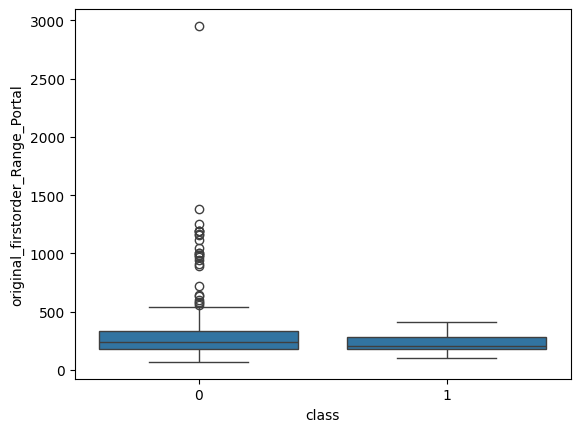

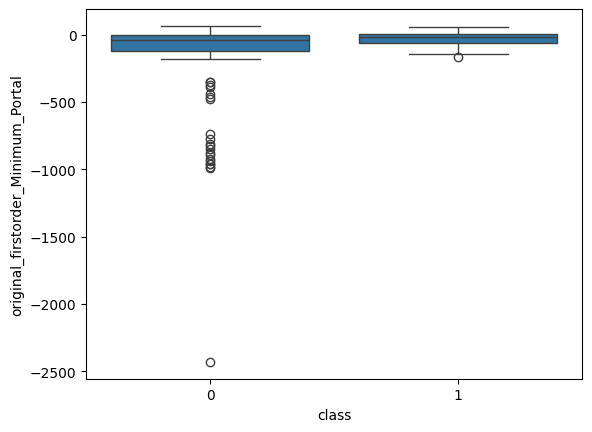

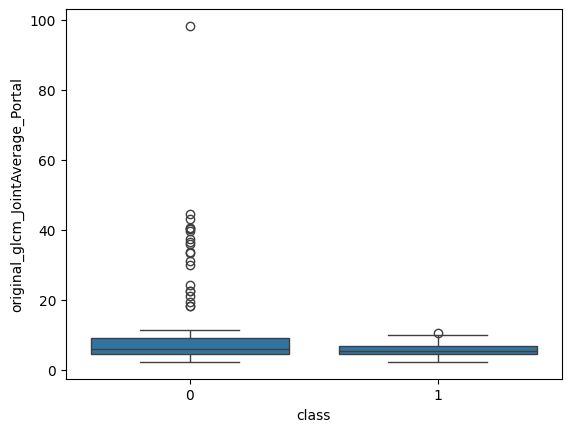

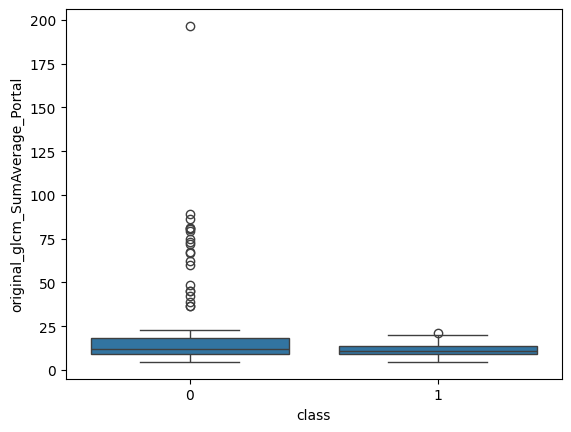

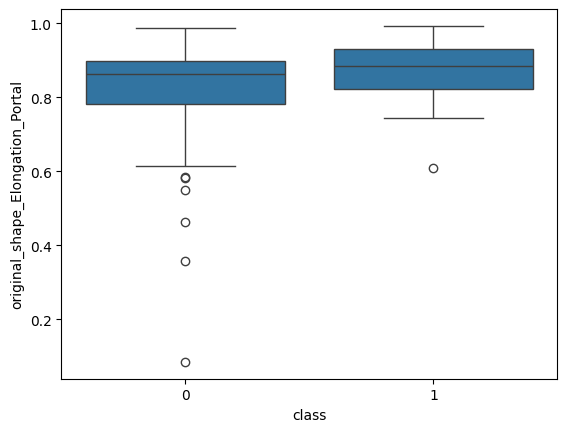

In [15]:
import seaborn as sbn # plotting library
import matplotlib.pyplot as plt

top_n = 5

ttest_results_sorted = sorted(ttest_results.keys(), key=lambda k: -ttest_results[k] ** 2)

for key in ttest_results_sorted[:top_n]:
    sbn.boxplot(x="class", y=key, data=train_radiomics_df)
    plt.show()

We now do the same for the clinical features. Clearly we see there are more radiomics features which are associated with the target variable - this could be a good indication!

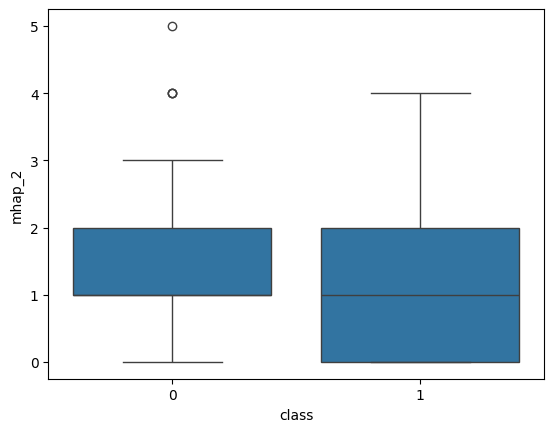

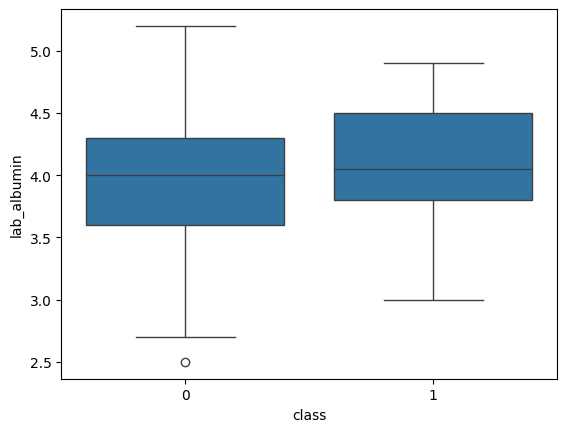

In [16]:
ttest_results_sorted = sorted(ttest_results_clinical.keys(), key=lambda k: -ttest_results_clinical[k] ** 2)

for key in ttest_results_sorted[:top_n]:
    sbn.boxplot(x="class", y=key, data=train_clinical_df)
    plt.show()

## Building our model

Here we will define a pipeline (`Pipeline`) containing a set of components which we have previously discussed are aluded to:

- `VarianceThreshold` will (mostly) remove constant features
- `StandardScaler` will scale the data such that each feature has $\mu=0$ and $\sigma=1$
- `RandomForestClassifier` will be our random forest classifier

We will first assess the expected performance of our method for hyperparameter selection using nested cross-validation. We will be performing this for three distinct feature sets:

1. Radiomics
2. Clinical (all of the clinical features)
3. Radclin (radiomics _and_ clinical features)

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from scipy.stats import randint

df_dict = {
    "radiomics": train_radiomics_df,
    "clinical": train_clinical_df,
    "full": train_full_df,
}

results = {}
inner_folds = 5
outer_folds = 5

for key in df_dict:
    np.random.seed(42)
    params = {
        "model__n_estimators": randint(5, 100),
        "model__max_depth": randint(5, 20)
    }
    pipeline = Pipeline(
        [("variance_threshold", VarianceThreshold()),
         ("scaler", StandardScaler()),
         ("model", RandomForestClassifier(
             class_weight="balanced",
             random_state=42))]
    )
    curr_df = df_dict[key]
    print(f"Training with {key} data (shape={curr_df.shape})")
    X = curr_df.drop("class", axis=1).astype(np.float32).to_numpy()
    y = curr_df["class"].to_numpy()

    inner_cv = StratifiedKFold(
        n_splits=inner_folds, shuffle=True, random_state=42)
    outer_cv = StratifiedKFold(
        n_splits=outer_folds, shuffle=True, random_state=42)

    inner_model = RandomizedSearchCV(
        pipeline, params, cv=inner_cv, n_iter=100, scoring="roc_auc", 
        random_state=42)
    nested_score = cross_validate(
        inner_model, 
        X=X, 
        y=y, 
        cv=outer_cv,
        scoring="roc_auc", 
        verbose=2, 
        return_estimator=True,
        n_jobs=min([outer_folds, 7]),
        )

    results[key] = nested_score

    print(key, np.mean(results[key]["test_score"]))

Training with radiomics data (shape=(170, 220))


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/home/jose_almeida/micromamba/envs/total_segmentator/lib/python3.12/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   37.6s remaining:   56.4s
/home/jose_almeida/micromamba/envs/total_segmentator/lib/python3.12/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[CV] END .................................................... total time=  36.6s
[CV] END .................................................... total time=  36.6s
[CV] END .................................................... total time=  36.7s


/home/jose_almeida/micromamba/envs/total_segmentator/lib/python3.12/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/jose_almeida/micromamba/envs/total_segmentator/lib/python3.12/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   51.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=  49.7s
[CV] END .................................................... total time=  49.7s
radiomics 0.7085064102564103
Training with clinical data (shape=(170, 28))
[CV] END .................................................... total time=  27.3s
[CV] END .................................................... total time=  27.3s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   27.4s remaining:   41.0s


[CV] END .................................................... total time=  27.5s
[CV] END .................................................... total time=  38.7s
[CV] END .................................................... total time=  38.8s
clinical 0.5398547008547008
Training with full data (shape=(170, 246))


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   38.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=  36.3s
[CV] END .................................................... total time=  36.6s
[CV] END .................................................... total time=  36.8s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   36.6s remaining:   55.0s


[CV] END .................................................... total time=  50.0s
[CV] END .................................................... total time=  50.2s
full 0.6505405982905983


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   50.2s finished


<Axes: xlabel='AUC', ylabel='Features'>

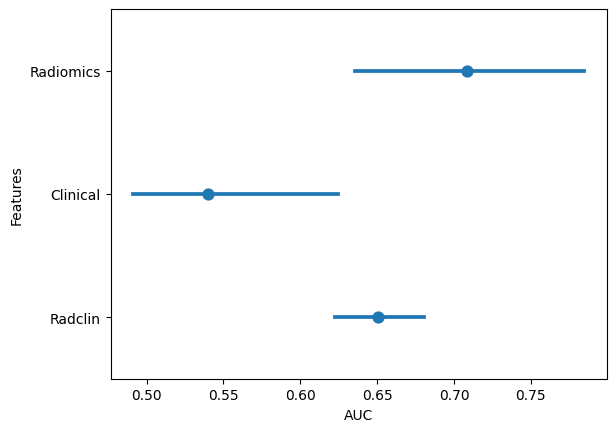

In [18]:
results_df = pd.DataFrame(
    {"AUC": np.concatenate([
        results['radiomics']['test_score'],
        results['clinical']['test_score'],
        results['full']['test_score']
        ]),
     "Features": np.concatenate(
        [["Radiomics" for _ in range(outer_folds)],
         ["Clinical" for _ in range(outer_folds)],
         ["Radclin" for _ in range(outer_folds)]])}
     )

sbn.pointplot(x="AUC", y="Features", data=results_df, linestyle='')

In [19]:
from scipy import stats

print("Radiomics vs. clinical:", stats.ttest_ind(results["radiomics"]["test_score"], results["clinical"]["test_score"]))
print("Radiomics+clinical vs. clinical:", stats.ttest_ind(results["full"]["test_score"], results["clinical"]["test_score"])) 
print("Radiomics vs. radiomics+clinical:", stats.ttest_ind(results["radiomics"]["test_score"], results["full"]["test_score"]))

Radiomics vs. clinical: TtestResult(statistic=np.float64(2.789188911773895), pvalue=np.float64(0.023587800569580653), df=np.float64(8.0))
Radiomics+clinical vs. clinical: TtestResult(statistic=np.float64(2.4316442397877522), pvalue=np.float64(0.041096694330042004), df=np.float64(8.0))
Radiomics vs. radiomics+clinical: TtestResult(statistic=np.float64(1.2594030597138708), pvalue=np.float64(0.24338545132222947), df=np.float64(8.0))


In [21]:
import joblib # here we are using this library to save our model
import os

os.makedirs("model", exist_ok=True)
joblib.dump(results, "model/all_models.joblib")

['model/all_models.joblib']

Excellent! We appear to have an improvement on progression prediction both using radiomic features and using all features (clinical and radiomics).

We are only missing one last part of our approach: validating our models on our hold-out test set.

## Validation

In [22]:
test_full_df = full_df[np.in1d(full_df.identifier.astype(str), test_patients)]

test_radiomics_df = test_full_df.drop(relevant_columns, axis=1)
test_clinical_df = test_full_df[["identifier", *relevant_columns, "class"]]

/tmp/ipykernel_607635/157976779.py:1: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  test_full_df = full_df[np.in1d(full_df.identifier.astype(str), test_patients)]


In [ ]:
from sklearn.metrics import roc_auc_score

test_df_dict = {
    "radiomics": test_radiomics_df,
    "clinical": test_clinical_df,
    "full": test_full_df,
}

for key in test_df_dict:
    curr_df = test_df_dict[key]
    X = curr_df.drop("class", axis=1).astype(np.float32).to_numpy()
    y = curr_df["class"].to_numpy()

    probas = [estimator.predict_proba(X)[:, 1] 
              for estimator in results[key]["estimator"]]
    probas = np.array(probas).mean(0)

    predictions = [estimator.predict(X)
                   for estimator in results[key]["estimator"]]
    predictions = np.array(predictions).mean(0) > 0.5

    print(
        f"{key}: ROC={roc_auc_score(y, probas)}"
    )

radiomics: ROC=0.6846689895470384
clinical: ROC=0.5209059233449478
full: ROC=0.6829268292682926
